# PCA reconstructor

In [1]:
import os
import sys
import cv2 as cv
import numpy as np
import plotly.io as pio
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sb
import matplotlib.pyplot as plt
import inspect


from PIL import Image
from skimage import color
from plotly import subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def charge_image(path): # fonction pour charger dataset d'images en une liste d'arrays de taille 4096 chacun
  dir = path
  X = []
  X_flat = []
  size = 64

  for img in os.listdir(path):
      img_array = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE)
      img_pil = Image.fromarray(img_array)
      img_64x64 = np.array(img_pil.resize((size, size)))
      X.append(img_64x64)
      img_array = img_64x64.flatten()
      X_flat.append(img_array)
  return X_flat

In [4]:
# Chargement data et preprocessing
train_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/train/good'
test_dir = '/content/drive/MyDrive/EA_MAP/transistor/transistor/test/good'
X = []
Y = []
X_flat = []
X_test = []
size = 64

for img in os.listdir(train_dir):
    img_array = cv.imread(os.path.join(train_dir, img), cv.IMREAD_GRAYSCALE)
    img_pil = Image.fromarray(img_array)
    img_64x64 = np.array(img_pil.resize((size, size)))
    X.append(img_64x64)
    img_array = img_64x64.flatten()
    X_flat.append(img_array)

for img in os.listdir(test_dir):
    img_array = cv.imread(os.path.join(test_dir, img), cv.IMREAD_GRAYSCALE)
    img_pil = Image.fromarray(img_array)
    img_64x64 = np.array(img_pil.resize((size, size)))
    Y.append(img_64x64)
    img_array = img_64x64.flatten()
    X_test.append(img_array)

In [5]:
# on regarde quelques images du dataset d'entraînement
size = 5
count = 0
fig = subplots.make_subplots(rows = size, cols = size,
                 vertical_spacing = 0.06, horizontal_spacing = 0.02)
for row in range(size):
  for col in range(size):
    fig.add_trace(go.Image(z = color.gray2rgb(X[count])),
                  row = row + 1, col = col + 1)
    count += 1
fig["layout"].update(title = "Images de transistors", height = 900)
fig.show()

In [6]:
X_flat = np.asarray(X_flat)

In [7]:
m = np.mean(X_flat, axis=0)
var = np.std(X_flat, axis=0)
for k in range(len(var)):
  if var[k] == 0:
    var[k] = 1
X_scaled = (X_flat - np.mean(X_flat, axis=0))/np.std(X_flat, axis=0)
Xbar_test = (X_test - m)/var

## Manual PCA using the covariance matrix

Let's define a few useful functions to work with the datasets

In [8]:
def eig(S):
    eig_val, eig_vec = np.linalg.eigh(S)
    sorted_eig  = np.argsort(-eig_val)
    eig_val = eig_val[sorted_eig]
    eig_vec = eig_vec[:, sorted_eig]
    return (eig_val, eig_vec)

In [9]:
def projection_matrix(B):
    P = B @ B.T
    return P

In [10]:
def PCA(X, num_components): # prend une matrice standardisée en entrée
    S = np.cov(X.T)
    eig_vals, eig_vecs = eig(S)
    U = eig_vecs[:, range(num_components)]
    P = projection_matrix(U)
    return P

In [11]:
# Résidu MSE
def mse(predict, actual):
    return np.square(predict - actual).sum(axis = 1).mean()

Let's look at the explained deviation of the dataset depending on the number of principal components we project our matrix on

In [12]:
matrice_cov = np.cov(X_scaled.T)
eig_vals, eig_vecs = eig(matrice_cov)

# Calcul de la variance expliquée
def explained_var(spectre): # prend liste des valeurs propres de la matrice de covariance rescale en entrée
  variance_expliquee = [val / sum(spectre) for val in spectre]
  variance_expliquee_cumulee = np.cumsum(variance_expliquee)
  return variance_expliquee_cumulee

def lim_var(spectre, lim): # lim compris entre 0 et 1, pour décider combien on prend de PC pour avoir telle variance expliquée
  var = explained_var(spectre)
  i = 0
  while var[i] < lim:
    i += 1
  return i

# Création du graphique
fig = px.line(x=range(1, len(eig_vals) + 1), y=explained_var(eig_vals),
              markers=True,
              labels={'x': 'Nombre de composantes principales', 'y': 'Variance expliquée cumulée'},
              title='Variance expliquée en fonction du nombre de composantes principales')

fig.show()

In [13]:
# Calcul de perte MSE et reconstruction d'images
loss = []
reconstructions = []
max_components = 20
for num_component in range(1, max_components + 1):
    U = eig_vecs[:, range(num_component)]
    P = projection_matrix(U)
    reconst = Xbar_test @ P
    error = mse(reconst, Xbar_test) # erreur entre images rescaled ou pas ?
    reconstructions.append(reconst)
    loss.append((num_component, error))

In [14]:
# Rescale des images reconstruites
reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions * np.std(X_test, axis=0) + np.mean(X_test, axis=0)
loss = np.asarray(loss)
print("Done")

Done


We now try to reconstruct the images thanks to the dimensional-reducted matrix of each image

In [15]:
def reconst_pca(X, n): # reconstruit une classe entière avec n composantes principales, renvoie des images en 64x64
  #m = np.mean(X, axis=0) # moyenne de chaque pixel
  #var = np.std(X, axis=0) # variance de chaque pixel
  U = eig_vecs[:, range(n)]
  P = projection_matrix(U)
  '''for k in range(len(var)):
    if var[k] == 0:
      var[k] = 1'''
  X = (X-m)/var # standardisation de la matrice, avec la moyenne et la variance du dataset d'entraînement
  reconst_scaled = X @ P # PCA
  reconst = reconst_scaled * var + m # reconstruction de la matrice
  images_reshaped = [reconst[k] for k in range(len(reconst))] # en taille 4096
  return images_reshaped

def show_reconst_image(X, n, k): # renvoie la k-ème image reconstruite de la classe reconstruite avec n composantes principales
  image_reshaped = reconst_pca(X, n)[k].reshape(64, 64)
  plt.imshow(image_reshaped, cmap='gray')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title(f'Image reconstruite avec {n} PC')
  plt.show()
  return

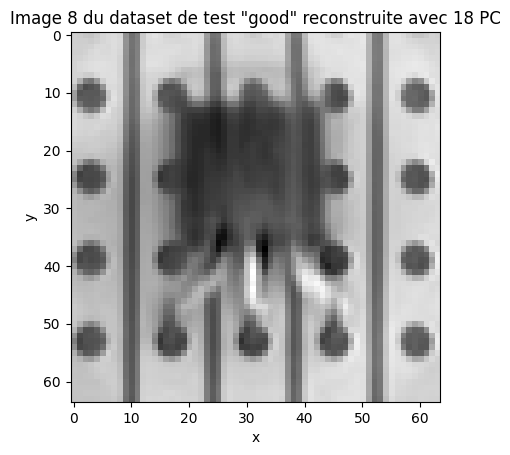

In [16]:
# Afficher une image reconstruite avec une variance expliquée à 95 %
n = lim_var(eig_vals, 0.8)
U = eig_vecs[:, range(n)]
P = projection_matrix(U)
reconstructed = Xbar_test @ P
reconstructed = reconstructed * var + m # reconstruction avec la moyenne et la variance du dataset d'entraînement
im = 8
image_reshaped = reconstructed[im].reshape(64, 64)
plt.imshow(image_reshaped, cmap='gray')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Image {im} du dataset de test "good" reconstruite avec {n} PC')
plt.show()



We now work with abnormal images to see if our algorithm is able to detect the wrong transistors

In [17]:
X_flat_damaged = charge_image('/content/drive/MyDrive/EA_MAP/transistor/transistor/test/damaged_case')
X_flat_cut = charge_image('/content/drive/MyDrive/EA_MAP/transistor/transistor/test/cut_lead')
X_flat_bent = charge_image('/content/drive/MyDrive/EA_MAP/transistor/transistor/test/bent_lead')
X_flat_misplaced = charge_image('/content/drive/MyDrive/EA_MAP/transistor/transistor/test/misplaced')
X_flat_good = charge_image('/content/drive/MyDrive/EA_MAP/transistor/transistor/test/good')

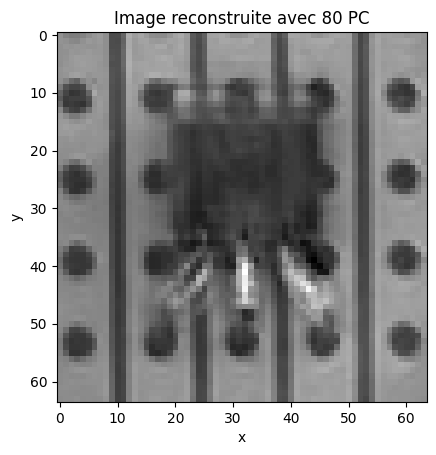

In [18]:
show_reconst_image(X_flat_damaged, 80, 0)

In [19]:
def mse_im(predict,actual): # perte mse entre deux images
    return np.square(predict - actual).sum()


In [20]:
n = 18
def loss(X): # perte d'une classe (liste des pertes mse entre image réelle et image reconstruite)
  loss =[]
  reconst = reconst_pca(X, n)
  for k in range(len(reconst)):
    loss_i = mse_im(reconst[k].reshape(64,64), X[k].reshape(64,64))
    loss.append(loss_i)
  return loss

In [21]:
loss_damaged = loss(X_flat_damaged)
loss_cut = loss(X_flat_cut)
loss_bent = loss(X_flat_bent)
loss_misplaced = loss(X_flat_misplaced)
loss_good = loss(X_flat_good)
loss_norm = loss(X_flat)

In [22]:
def show_box_chart(list):  # renvoie boîtes à moustache, liste des loss que l'on veut considérer
  fig = go.Figure()
  fig.add_trace(go.Box(
        y=loss_norm,
        name=f'Loss from training set',
        marker_color='blue'
    ))

  for k in range(len(list)):
    fig.add_trace(go.Box(
        y=list[k],
        name=f'Loss {k}',
        marker_color='red'
    ))


  # Mettre à jour la disposition pour les afficher l'une en dessous de l'autre
  fig.update_layout(
      title='Comparaison des pertes',
      yaxis_title='Valeurs de perte',
      boxmode='group',  # Afficher les boxplots l'un en dessous de l'autre
      showlegend=True
  )

  # Afficher le graphique
  fig.show()
  return

In [23]:
show_box_chart([loss_good, loss_damaged, loss_cut, loss_bent, loss_misplaced])

Let's plot the rates of true positive and false positive with the loss boundary as a variable

In [24]:
#creating the test batches
#critères: -1 s'il y a une anomalie et 1 si l'image est normale

loss_misplaced_test = [[loss_misplaced[i], -1] for i in range(len(loss_misplaced))]

loss_good_test = [[loss_good[i], 1] for i in range(len(loss_good))]

loss_cut_test = [[loss_cut[i], -1] for i in range(len(loss_cut))]

loss_bent_test = [[loss_bent[i], -1] for i in range(len(loss_bent))]

loss_damaged_test = [[loss_damaged[i], -1] for i in range(len(loss_damaged))]


In [25]:
#Critère d'anomalie/Anomaly map

def anomaly_map(value, map_boundary):
  # renvoie 1 si anomalie et -1 sinon, en fonction de map_boundary
  return 2*int(value[0]<map_boundary) - 1


def false_evaluation(value, map_boundary):
  # renvoie 0 si l'évaluation est bonne et 1 sinon
  return 1 - int(anomaly_map(value, map_boundary) * value[1] == 1)

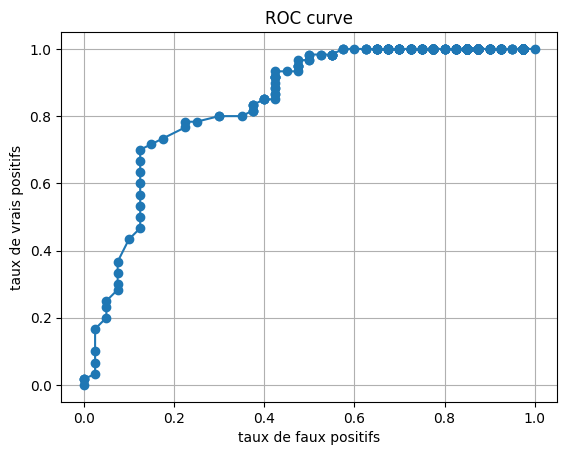

In [26]:
#créer la liste des map_boundaries

map_boundaries = np.linspace(np.min(loss_good)-1,np.max([np.max(loss_misplaced),np.max(loss_cut)])+1,1000)

#compte du taux de faux positifs et négatifs pour chaque map_boundary

num_positif = len(loss_good)

num_negatif = len(loss_misplaced) + len(loss_cut) + len(loss_bent) + len(loss_damaged)

num_tot = num_positif + num_negatif

taux_boundary = []

for i in range(len(map_boundaries)):
  x = 0
  for k in range(len(loss_misplaced_test)):
    x += false_evaluation(loss_misplaced_test[k], map_boundaries[i])
  for k in range(len(loss_cut_test)):
    x += false_evaluation(loss_cut_test[k], map_boundaries[i])
  for k in range(len(loss_bent_test)):
    x += false_evaluation(loss_bent_test[k], map_boundaries[i])
  for k in range(len(loss_damaged_test)):
    x += false_evaluation(loss_damaged_test[k], map_boundaries[i])
  y = 0
  for k in range(len(loss_good)):
    y += false_evaluation(loss_good_test[k], map_boundaries[i])
  taux_boundary.append([x/num_negatif, 1 - (y/ num_positif), map_boundaries[i]])

plt.plot(np.transpose(taux_boundary)[0],np.transpose(taux_boundary)[1], marker = "o")
plt.grid()
plt.title("ROC curve")
plt.xlabel("taux de faux positifs")
plt.ylabel("taux de vrais positifs")

plt.show()

In [27]:
#choix des valeurs frontières pour lesquelles le taux de faux positifs et négatifs = 0

bonnes_frontieres = []
min =[]
min_value = 2


for i in range(len(taux_boundary)):
    if taux_boundary[i][0]**2 + (taux_boundary[i][1]-1)**2 < min_value:
      min_value = taux_boundary[i][0]**2 + (taux_boundary[i][1]-1)**2
      min = taux_boundary[i]

print("Valeur optimale pour la frontière:" , min[2])

Valeur optimale pour la frontière: 411370.714167617


In [28]:
#Code pour l'AUC

auc = np.trapz(np.transpose(taux_boundary)[1], np.transpose(taux_boundary)[0])

print("AUC :" , auc)

AUC : 0.8379166666666666


27
[[0.78333333 0.225     ]
 [0.21666667 0.775     ]]


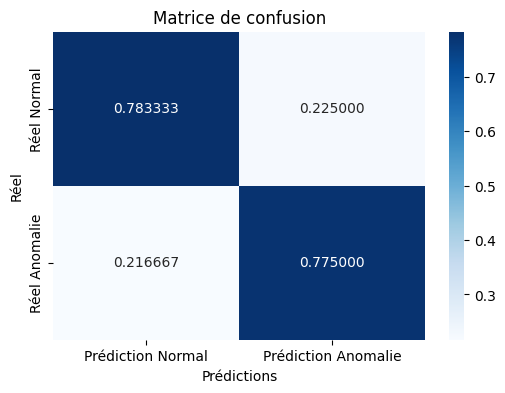

In [29]:
#plotting the confusion matrix

idx_optimal = 0
for i in range(len(taux_boundary)):
  if taux_boundary[i][2] == min[2]:
    idx_optimal = i

print(idx_optimal)


confusion_matrix = np.zeros((2,2))

confusion_matrix[0,1] = taux_boundary[idx_optimal][0]
confusion_matrix[0,0] = taux_boundary[idx_optimal][1]
confusion_matrix[1,0] = 1 - taux_boundary[idx_optimal][1]
confusion_matrix[1,1] = 1 - taux_boundary[idx_optimal][0]

print(confusion_matrix)

plt.figure(figsize=(6, 4))
sb.heatmap(confusion_matrix, annot=True, fmt='f', cmap='Blues', xticklabels=['Prédiction Normal', 'Prédiction Anomalie'], yticklabels=['Réel Normal', 'Réel Anomalie'])
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion')

# Affichage
plt.show()

## Comparison with the PCA from sklearn

In [30]:
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [31]:
pca = PCA(n_components=18)
pca.fit(X_scaled)
pca_max = PCA(n_components = 213)
pca_max.fit(X_scaled)
X_pca = pca.transform(X_scaled)
principalComponents = pca.fit_transform(X_scaled)

In [32]:
def scaler(X):
  X = (X-m)/var # on scale avec la moyenne et la variance du dataset
  return X

In [33]:
list_var = np.cumsum(pca_max.explained_variance_ratio_)
fig = px.line(x=range(1, len(list_var) + 1), y=list_var,
              labels={'x': 'Nombre de composantes principales', 'y': 'Variance expliquée cumulée'},
              markers = True,
              title='Variance expliquée en fonction du nombre de composantes principales')
fig.show()

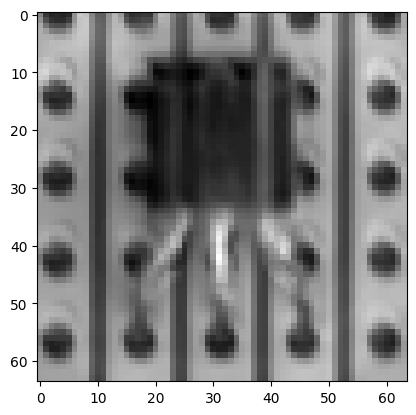

In [34]:
X_inverse = pca.inverse_transform(X_pca)* var + m
plt.figure()
plt.imshow(X_inverse[0].reshape(64,64), cmap='gray')
plt.show()

In [35]:
def loss_pca(X, pca):
  loss =[]
  X_scaled = (X-m)/var
  X_pca = pca.transform(X_scaled)
  reconst = pca.inverse_transform(X_pca)*var + m
  for k in range(len(reconst)):
    loss_i = mse_im(reconst[k].reshape(64,64), X[k].reshape(64,64))
    loss.append(loss_i)
  return loss

In [36]:
loss_pca_norm = loss_pca(X_flat, pca)
loss_pca_damaged = loss_pca(X_flat_damaged, pca)
loss_pca_cut = loss_pca(X_flat_cut, pca)
loss_pca_bent = loss_pca(X_flat_bent, pca)
loss_pca_misplaced = loss_pca(X_flat_misplaced, pca)
loss_pca_good = loss_pca(X_flat_good, pca)
loss_pca_norm = loss_pca(X_flat, pca)

In [37]:
def show_box_chart_pca(list):  # renvoie boîtes à moustache, liste des loss que l'on veut considérer
  fig = go.Figure()
  fig.add_trace(go.Box(
        y=loss_pca_norm,
        name=f'Loss pca from training set',
        marker_color='blue'
    ))

  for k in range(len(list)):
    fig.add_trace(go.Box(
        y=list[k],
        name=f'Loss {k}',
        marker_color='red'
    ))


  # Mettre à jour la disposition pour les afficher l'une en dessous de l'autre
  fig.update_layout(
      title='Comparaison des pertes',
      yaxis_title='Valeurs de perte',
      boxmode='group',  # Afficher les boxplots l'un en dessous de l'autre
      showlegend=True
  )

  # Afficher le graphique
  fig.show()
  return

In [38]:
show_box_chart_pca([loss_pca_good, loss_pca_damaged, loss_pca_cut, loss_pca_bent, loss_pca_misplaced])

We can see that both "manual" PCA and Python PCA give the same results for the loss distributions. The losses of the training set (normal images) and the test set (normal images) have almost the same distribution, and the losses of the tests with abnormal images have completely different distributions. This suggests that it is possible to determine whether a given test image is normal or not, by defining a threshold for the loss.

Let's plot the ROC curve for the PCA from Python

In [39]:
# -1 si l'image est anormale, 1 si elle est normale
loss_pca_misplaced_test = [[loss_pca_misplaced[i], -1] for i in range(len(loss_pca_misplaced))]

loss_pca_good_test = [[loss_pca_good[i], 1] for i in range(len(loss_pca_good))]

loss_pca_cut_test = [[loss_pca_cut[i], -1] for i in range(len(loss_pca_cut))]

loss_pca_bent_test = [[loss_pca_bent[i], -1] for i in range(len(loss_pca_bent))]

loss_pca_damaged_test = [[loss_pca_damaged[i], -1] for i in range(len(loss_pca_damaged))]

loss_pca_total = loss_pca_good + loss_pca_misplaced + loss_pca_cut + loss_pca_bent + loss_pca_damaged
loss_pca_total_test = loss_pca_good_test + loss_pca_misplaced_test + loss_pca_cut_test + loss_pca_bent_test + loss_pca_damaged_test
loss_pca_total_test = np.asarray(loss_pca_total_test)

In [40]:
map_pca_boundaries = np.linspace(
    np.min(loss_pca_good) - 1,
    np.max([np.max(loss_pca_misplaced), np.max(loss_pca_cut), np.max(loss_pca_bent), np.max(loss_pca_damaged)]) + 1,
    1000
)

In [41]:
num_pca_positif = len(loss_pca_good)

num_pca_negatif = len(loss_pca_misplaced) + len(loss_pca_cut) + len(loss_pca_bent) + len(loss_pca_damaged)

num_pca_tot = num_pca_positif + num_pca_negatif

taux_pca_boundary = []

for i in range(len(map_pca_boundaries)):
  x = 0
  for k in range(len(loss_pca_misplaced_test)):
    x += false_evaluation(loss_pca_misplaced_test[k], map_pca_boundaries[i])
  for k in range(len(loss_pca_cut_test)):
    x += false_evaluation(loss_pca_cut_test[k], map_pca_boundaries[i])
  for k in range(len(loss_pca_bent_test)):
    x += false_evaluation(loss_pca_bent_test[k], map_pca_boundaries[i])
  for k in range(len(loss_pca_damaged_test)):
    x += false_evaluation(loss_pca_damaged_test[k], map_pca_boundaries[i])
  y = 0
  for k in range(len(loss_pca_good)):
    y += false_evaluation(loss_pca_good_test[k], map_pca_boundaries[i])
  taux_pca_boundary.append([x/num_pca_negatif, 1 - (y/ num_pca_positif), map_pca_boundaries[i]])

In [42]:
X_roc = X_flat_good + X_flat_damaged + X_flat_cut + X_flat_bent + X_flat_misplaced
X_roc = np.asarray(X_roc)

In [43]:
bonnes_frontieres_pca = []
min_pca =[]
min_value_pca = 2


for i in range(len(taux_pca_boundary)):
    if taux_pca_boundary[i][0]**2 + (taux_pca_boundary[i][1]-1)**2 < min_value_pca:
      min_value_pca = (taux_pca_boundary[i][0])**2 + (taux_pca_boundary[i][1]-1)**2
      min_pca = taux_pca_boundary[i]

print("Valeur optimale pour la frontière:" , min_pca[2])

Valeur optimale pour la frontière: 411552.7014273859


In [44]:
y_pred = []
for k in loss_pca_total :
  if k < min_pca[2]:
    y_pred.append(-1)
  else:
    y_pred.append(1)

In [51]:
fpr, tpr, threshold = roc_curve(loss_pca_total_test[:,1], loss_pca_total_test[:,0], pos_label=1, drop_intermediate=False)
roc_auc = roc_auc_score(loss_pca_total_test[:,1], loss_pca_total_test[:,0])
print(len(threshold))
print("AUC :" , roc_auc)
#

101
AUC : 0.16333333333333333


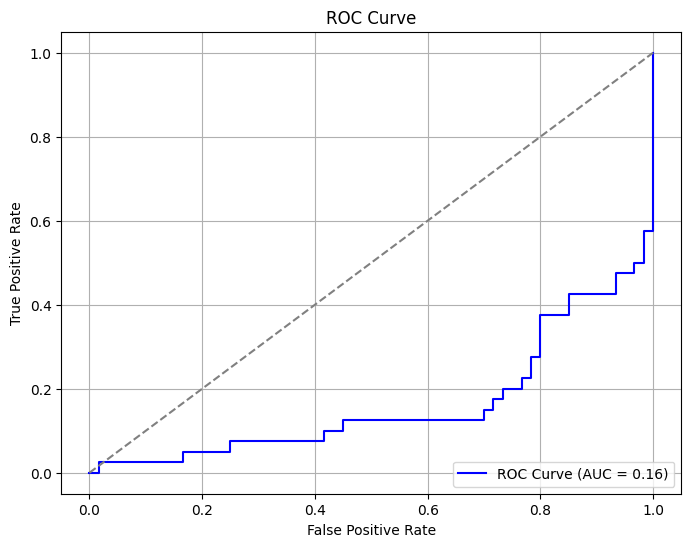

In [52]:
plt.figure(figsize=(8, 6))
plt.plot(1-tpr, 1-fpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

We have approximately the same curve as the one we got with manual PCA. Indeed, $AUC_{ manual} = 0.8379$ and $AUC_{scikit} = 0.8370$. The difference between both curves probably comes from the fact that function $roc\_curve$ uses a batch of 101 losses, named threshold, which is different from our method, where we use every possibility of loss. Let's try to use the same thresholds for both methods.

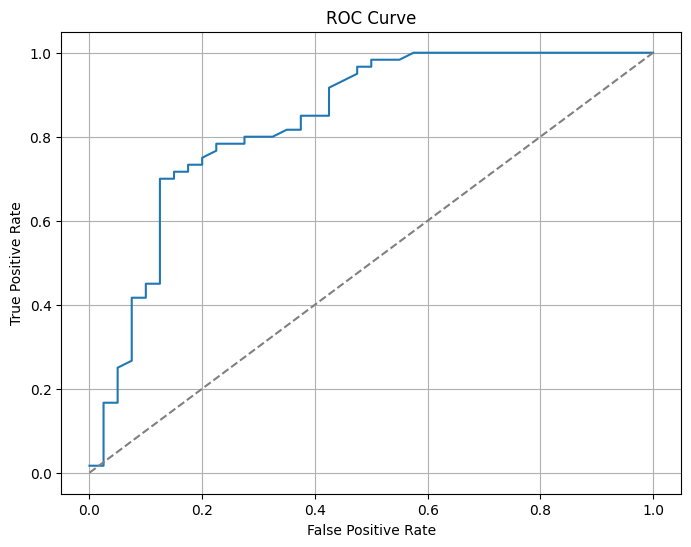

In [53]:
#créer la liste des map_boundaries

map_boundaries = threshold

#compte du taux de faux positifs et négatifs pour chaque map_boundary

num_positif = len(loss_good)

num_negatif = len(loss_misplaced) + len(loss_cut) + len(loss_bent) + len(loss_damaged)

num_tot = num_positif + num_negatif

taux_boundary = []

for i in range(len(map_boundaries)):
  x = 0
  for k in range(len(loss_misplaced_test)):
    x += false_evaluation(loss_misplaced_test[k], map_boundaries[i])
  for k in range(len(loss_cut_test)):
    x += false_evaluation(loss_cut_test[k], map_boundaries[i])
  for k in range(len(loss_bent_test)):
    x += false_evaluation(loss_bent_test[k], map_boundaries[i])
  for k in range(len(loss_damaged_test)):
    x += false_evaluation(loss_damaged_test[k], map_boundaries[i])
  y = 0
  for k in range(len(loss_good)):
    y += false_evaluation(loss_good_test[k], map_boundaries[i])
  taux_boundary.append([x/num_negatif, 1 - (y/ num_positif), map_boundaries[i]])

plt.figure(figsize=(8, 6))
plt.plot(np.transpose(taux_boundary)[0],np.transpose(taux_boundary)[1])
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()

In [54]:
#choix des valeurs frontières pour lesquelles le taux de faux positifs et négatifs = 0

bonnes_frontieres = []
min =[]
min_value = 2


for i in range(len(taux_boundary)):
    if taux_boundary[i][0]**2 + (taux_boundary[i][1]-1)**2 < min_value:
      min_value = taux_boundary[i][0]**2 + (taux_boundary[i][1]-1)**2
      min = taux_boundary[i]

print("Valeur optimale pour la frontière:" , min[2])

#Code pour l'AUC

auc = -np.trapz(np.transpose(taux_boundary)[1], np.transpose(taux_boundary)[0])

print("AUC :" , auc)

Valeur optimale pour la frontière: 407354.9713111177
AUC : 0.8374999999999999


Let's plot the Area Under the Curve depending on the number of components of the PCA we take, from 0 to 213, which is the length of our dataset (we have 4096 features but only 213 images).

In [55]:
y = []
for k in range(len(X_flat_good)):
  y.append(-1)
for k in range(len(X_flat_damaged) + len(X_flat_cut) + len(X_flat_bent) + len(X_flat_misplaced)):
  y.append(1)

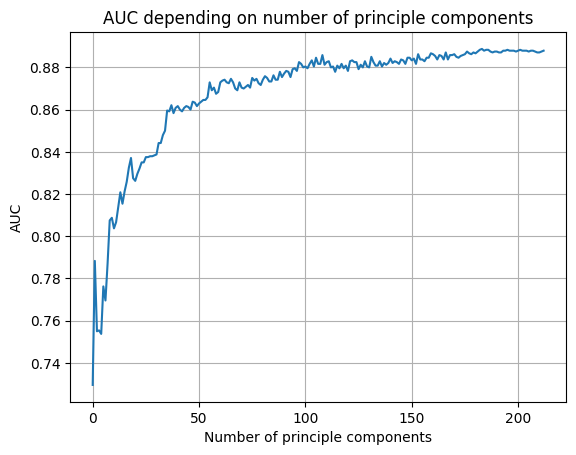

In [56]:
auc_list = []
components = np.arange(0,len(X_flat), 1)
for k in range(len(X_flat)):
  pca_auc = PCA(n_components=k)
  pca_auc.fit(X_scaled)
  loss_pca_auc_damaged = loss_pca(X_flat_damaged, pca_auc)
  loss_pca_auc_cut = loss_pca(X_flat_cut, pca_auc)
  loss_pca_auc_bent = loss_pca(X_flat_bent, pca_auc)
  loss_pca_auc_misplaced = loss_pca(X_flat_misplaced, pca_auc)
  loss_pca_auc_good = loss_pca(X_flat_good, pca_auc)
  loss_pca_auc_total = loss_pca_auc_good + loss_pca_auc_misplaced + loss_pca_auc_cut + loss_pca_auc_bent + loss_pca_auc_damaged
  roc_auc = roc_auc_score(y, loss_pca_auc_total)
  auc_list.append(roc_auc)

plt.figure()
plt.plot(components, auc_list)
plt.xlabel("Number of principle components")
plt.ylabel("AUC")
plt.title('AUC depending on number of principle components')
plt.grid()
plt.show()

